In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize 

In [29]:
data = yf.download(stocks, start='2020-01-01', end='2025-01-01', auto_adjust=True)
market = yf.download('^NSEI', start='2020-01-01', end='2025-01-01', auto_adjust=True)

data = data['Close']
market = market['Close']

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


In [30]:
returns = data.pct_change().dropna()
market_returns = market.pct_change().dropna()

In [31]:
annual_return = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)

risk_return_df = pd.DataFrame({
    "Annual Return": annual_return,
    "Annual Volatility": annual_volatility
})

print(risk_return_df)

              Annual Return  Annual Volatility
Ticker                                        
HDFCBANK.NS        0.112183           0.272640
ICICIBANK.NS       0.233337           0.317440
INFY.NS            0.254619           0.278557
RELIANCE.NS        0.162979           0.297307
TCS.NS             0.179412           0.244696


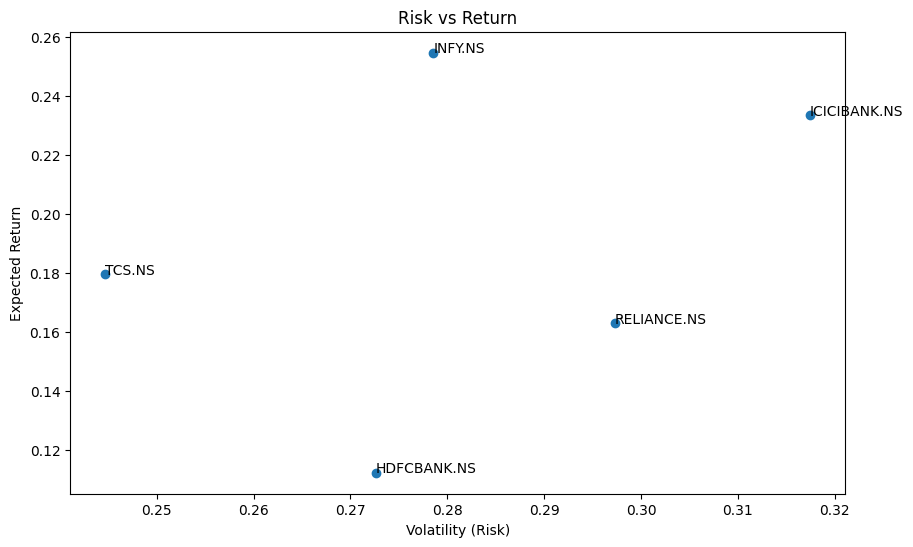

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(annual_volatility, annual_return)

for stock in stocks:
    plt.annotate(stock, 
                 (annual_volatility[stock], annual_return[stock]))

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Risk vs Return")
plt.show()

In [33]:
risk_free_rate = 0.07

sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
risk_return_df["Sharpe Ratio"] = sharpe_ratio

print(risk_return_df)

              Annual Return  Annual Volatility  Sharpe Ratio
Ticker                                                      
HDFCBANK.NS        0.112183           0.272640      0.154721
ICICIBANK.NS       0.233337           0.317440      0.514544
INFY.NS            0.254619           0.278557      0.662770
RELIANCE.NS        0.162979           0.297307      0.312738
TCS.NS             0.179412           0.244696      0.447133


In [34]:
betas = {}

for stock in stocks:
    
    # Combine stock and market returns into one DataFrame
    combined = pd.concat([returns[stock], market_returns], axis=1).dropna()
    
    combined.columns = ['Stock', 'Market']
    
    covariance = combined.cov().iloc[0,1]
    market_variance = combined['Market'].var()
    
    beta = covariance / market_variance
    betas[stock] = beta

risk_return_df["Beta"] = pd.Series(betas)
print(risk_return_df)

              Annual Return  Annual Volatility  Sharpe Ratio      Beta
Ticker                                                                
HDFCBANK.NS        0.112183           0.272640      0.154721  1.085276
ICICIBANK.NS       0.233337           0.317440      0.514544  1.292505
INFY.NS            0.254619           0.278557      0.662770  0.892562
RELIANCE.NS        0.162979           0.297307      0.312738  1.112326
TCS.NS             0.179412           0.244696      0.447133  0.750817


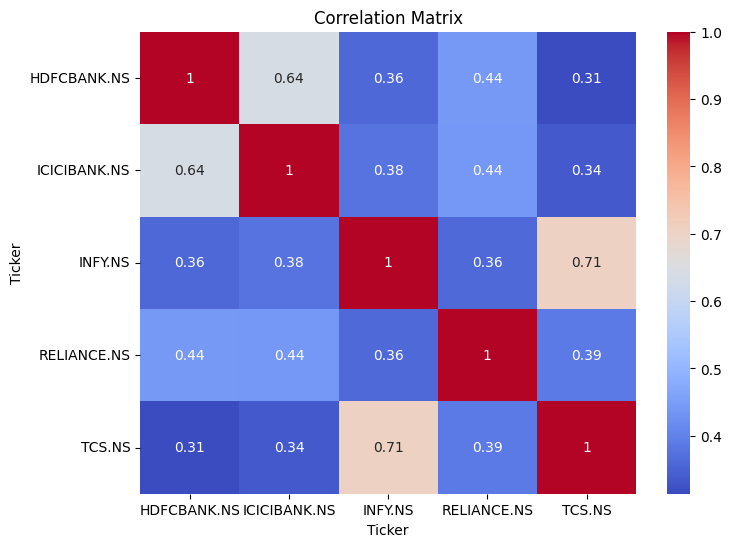

In [35]:
plt.figure(figsize=(8,6))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [36]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

In [37]:
num_portfolios = 10000
results = np.zeros((3, num_portfolios))

mean_returns = annual_return
cov_matrix = returns.cov() * 252

for i in range(num_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    
    portfolio_return, portfolio_std = portfolio_performance(weights, mean_returns, cov_matrix)
    
    results[0,i] = portfolio_std
    results[1,i] = portfolio_return
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std

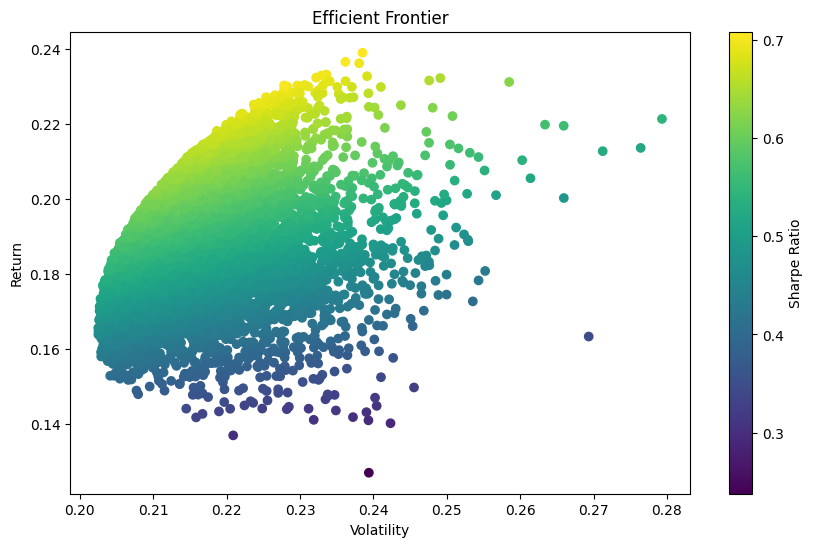

In [38]:
plt.figure(figsize=(10,6))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()

In [39]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[1, max_sharpe_idx]
max_sharpe_vol = results[0, max_sharpe_idx]

print("Maximum Sharpe Portfolio")
print("Return:", max_sharpe_return)
print("Volatility:", max_sharpe_vol)

Maximum Sharpe Portfolio
Return: 0.2388787482779963
Volatility: 0.2385145644944522


In [40]:
market_annual_return = market_returns.mean() * 252

capm_returns = risk_free_rate + risk_return_df["Beta"] * (market_annual_return - risk_free_rate)

risk_return_df["CAPM Expected Return"] = capm_returns

print(risk_return_df)

              Annual Return  Annual Volatility  Sharpe Ratio      Beta  \
Ticker                                                                   
HDFCBANK.NS        0.112183           0.272640      0.154721  1.085276   
ICICIBANK.NS       0.233337           0.317440      0.514544  1.292505   
INFY.NS            0.254619           0.278557      0.662770  0.892562   
RELIANCE.NS        0.162979           0.297307      0.312738  1.112326   
TCS.NS             0.179412           0.244696      0.447133  0.750817   

              CAPM Expected Return  
Ticker                              
HDFCBANK.NS                    NaN  
ICICIBANK.NS                   NaN  
INFY.NS                        NaN  
RELIANCE.NS                    NaN  
TCS.NS                         NaN  


In [41]:
VaR_95 = returns.quantile(0.05)
print("Value at Risk (95% confidence):")
print(VaR_95)

Value at Risk (95% confidence):
Ticker
HDFCBANK.NS    -0.024386
ICICIBANK.NS   -0.025320
INFY.NS        -0.024658
RELIANCE.NS    -0.024107
TCS.NS         -0.021524
Name: 0.05, dtype: float64
